# Clustering
In this notebook, we are trying out various clustering approaches, such as hierarchical clustering, time series k-means.

Our best approach turns out to be time series soft-dtw clustering, with a score of 4234.789427074525 for calinski_harabasz_score and \
3.144632570974739 for davies_bouldin_score.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1
!pip install -U neptune-client
!pip install -U neptune-sklearn
!pip install -U tslearn
!pip install missingno
!pip install hyperopt
!pip install neptune-notebooks
!jupyter nbextension enable --py neptune-notebooks

Found existing installation: scikit-learn 1.2.1
Uninstalling scikit-learn-1.2.1:
  Successfully uninstalled scikit-learn-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 32.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.3 MB/s e

In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import neptune
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import missingno
from scipy import stats
import math

# clustering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import uniform, randint
from tslearn.utils import to_time_series_dataset
from tslearn import clustering,preprocessing
from sklearn.decomposition import PCA
from tslearn.clustering import KernelKMeans,TimeSeriesKMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from tqdm import tqdm
import pickle
import os
import sys
seed=42

The scikit-learn version is 1.2.1.


In [ ]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing directly from CA4021 folder


In [ ]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot
from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model

In [ ]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path,'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path,'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [ ]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

In [ ]:
# selected variables from XGBoost notebook
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

In [ ]:
dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)
# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')
# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(df_train, df_test, 
                                     cat_vars=categorical, num_vars=continuous+discrete, cat_encoder='oh')
y_train = y.copy()
y_test = df_test[target]
# for compatibility with TimeSeriesSplit
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Time Series Kmeans

In [ ]:
X_train_kmeans = preprocessing.TimeSeriesScalerMinMax().fit_transform(X_train)

Text(0, 0.5, 'WCSS')

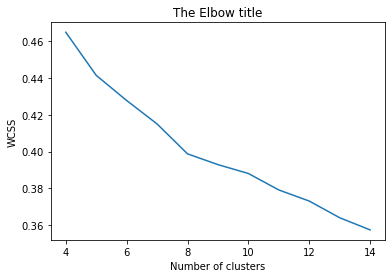

In [ ]:
# do not rerun!!!!

wcss=[]
for i in range(4,15):
  kmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw",verbose=True,random_state=seed)
  kmeans.fit(X_train)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(4,15)
plt.plot(range(4,15),wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

From above plot, we will choose k = 8

In [ ]:
X_train_kmeans.shape

(78888, 24, 1)

In [ ]:
km = TimeSeriesKMeans(n_clusters=8, metric="dtw",verbose=True,random_state=seed,tol=0.001)
y_pred = km.fit_predict(X_train_kmeans)

# Save the object to a file
with open(os.path.join(path, 'results/kmeans.pickle'), "wb") as file:
    pickle.dump(y_pred, file)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 78888 out of 78888 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   55.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   56.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   55.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   55.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315552 out of 315552 | elapsed:   55.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1

0.551 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.427 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.421 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.418 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.416 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.410 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.408 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.406 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.404 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


0.404 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 631104 out of 631104 | elapsed:  2.5min finished


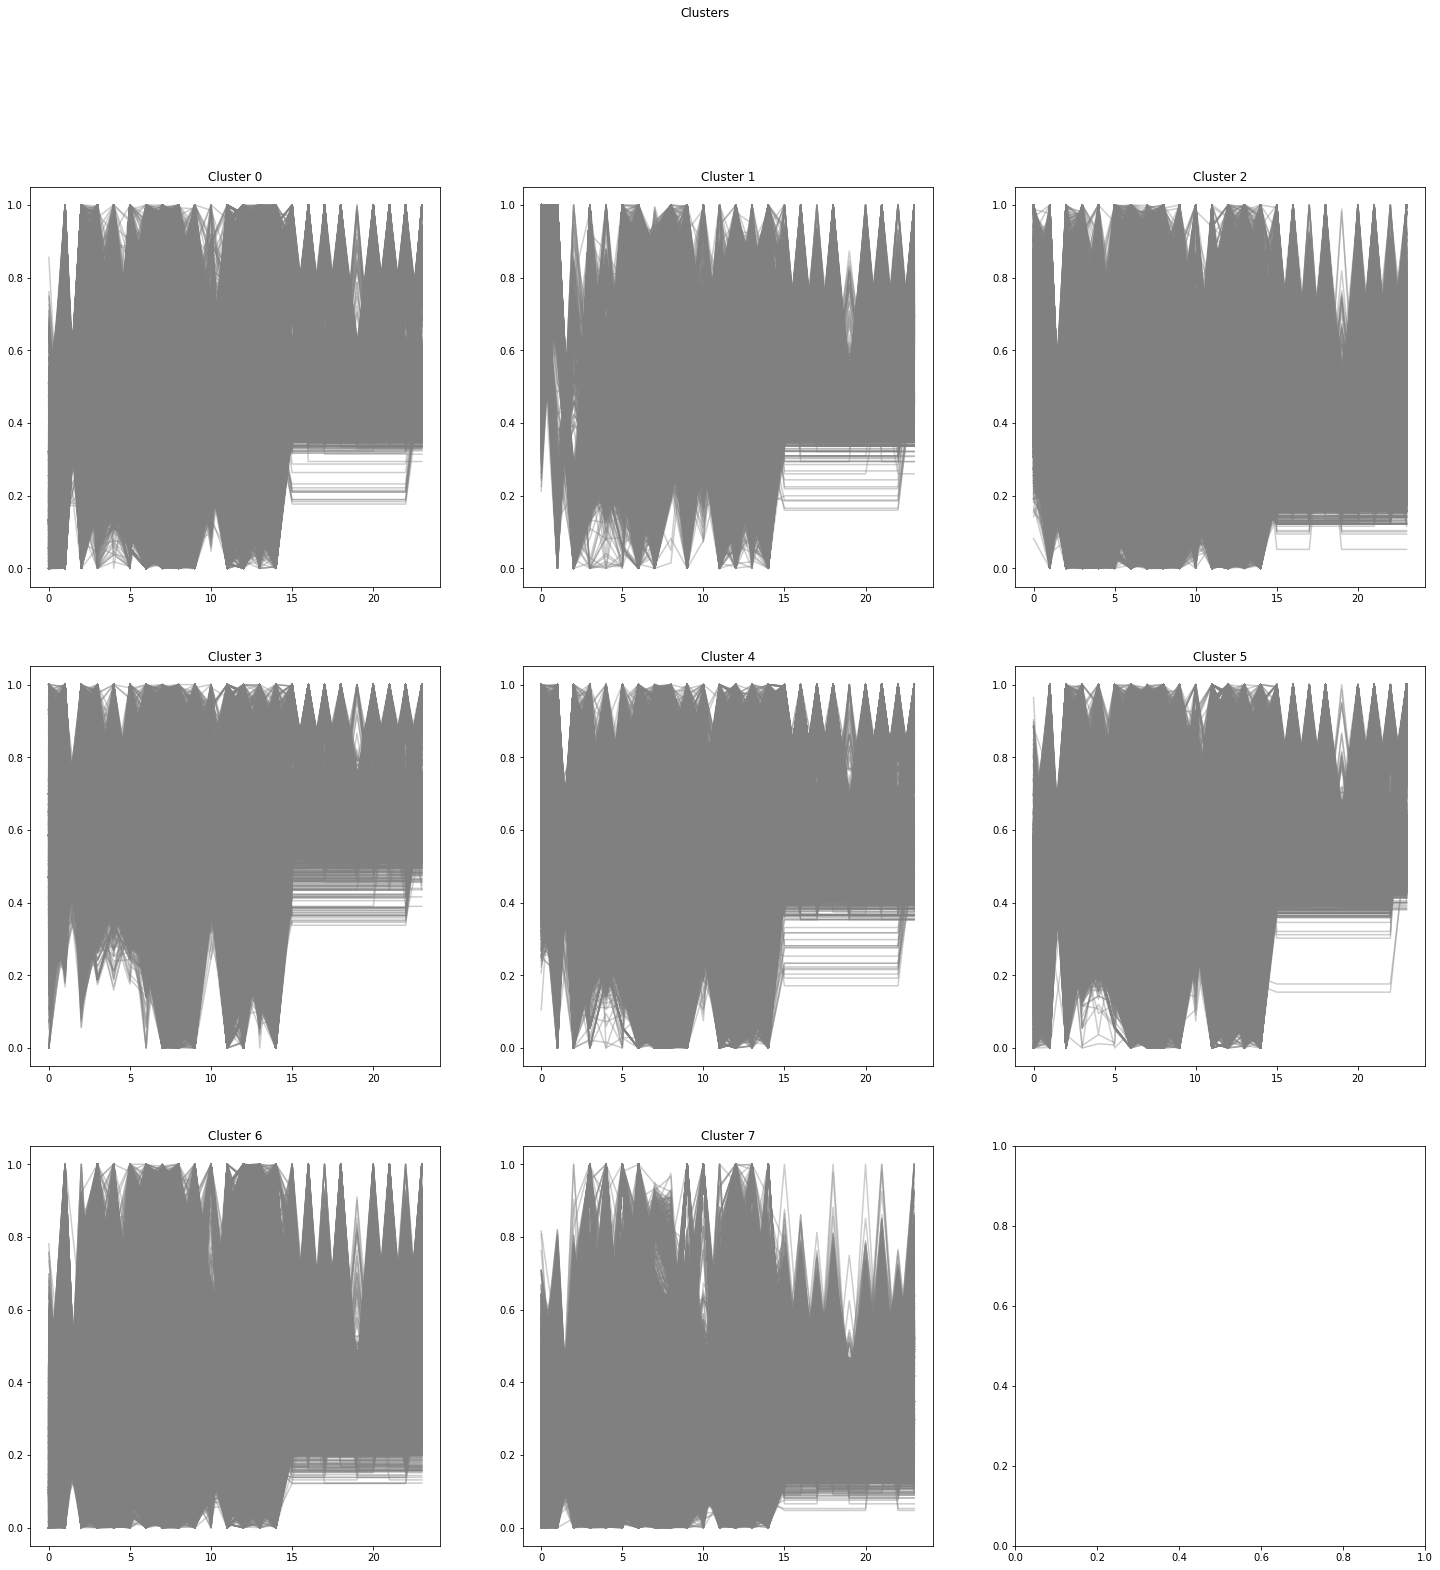

In [ ]:

plot_count = math.ceil(math.sqrt(8))

fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')
row_i = 0
column_j = 0
# For each label there is,
# plots every series with that label
for label in set(y_pred):
    cluster = []
    for i in range(len(y_pred)):
        if(y_pred[i] == label):
            axs[row_i, column_j].plot(X_train[i], c="gray", alpha=0.4)
            cluster.append(X_train_kmeans[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(
            np.vstack(cluster), axis=0), c="red")
    axs[row_i, column_j].set_title(
        "Cluster "+str(label))
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

plt.show()


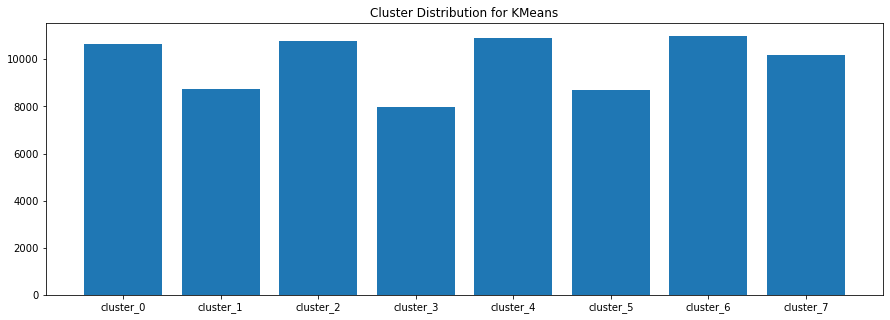

In [ ]:
cluster_c = [len(y_pred[y_pred == i]) for i in range(8)]
cluster_n = ["cluster_"+str(i) for i in range(8)]
plt.figure(figsize=(15, 5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n, cluster_c)
plt.show()


In [ ]:
# check kmeans clusters when we run without PCA, and then do PCA and colour on cluster
# 
X_train.head()

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,dir,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
0,-1.376079,-0.362191,0.305680,-0.432978,-0.416469,-0.749357,-0.855241,-0.786384,-0.865935,1.170655,-0.002102,0.592468,-0.652624,-0.804416,0.770863,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.376079,-0.573671,0.557907,-0.432978,-0.416469,-0.749357,-0.855241,-0.763574,-0.946414,1.170655,-0.002102,0.592468,-0.833040,-0.804416,0.892206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.445887,0.060768,-0.198772,-0.432978,-0.416469,-0.749357,-0.855241,-1.060103,-0.906174,1.145849,-0.002102,0.592468,-0.833040,-1.035018,0.770863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.445887,-0.658263,0.641982,-0.418409,-0.416469,-0.749357,-0.855241,-0.695144,-0.926294,1.129312,0.027427,0.592468,-0.652624,-0.738529,0.528175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.445887,-0.869742,0.978284,-0.403841,-0.416469,-0.749357,-0.855241,-0.603904,-0.946414,1.129312,0.056956,0.592468,-0.652624,-0.672643,0.892206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
y_pred

array([0, 0, 5, ..., 5, 5, 5])

In [ ]:
# doing PCA on our data, and then presenting clusters

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X_train_kmeans.reshape(78888,24))

In [ ]:
plt.figure(figsize=(35,25))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_pred, s=25)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

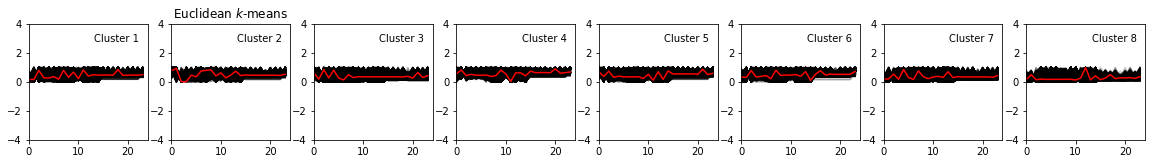

In [ ]:
plt.figure(figsize=(20,20))
for yi in range(8):
    plt.subplot(8, 8, yi + 1)
    for xx in X_train_kmeans[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_train_kmeans.shape[1])
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85, 'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")


In [ ]:
print(metrics.calinski_harabasz_score(X_train_kmeans.reshape(78888,24), y_pred))
print(metrics.davies_bouldin_score(X_train_kmeans.reshape(78888,24), y_pred))

4229.981879387158
3.382012643538925


In [ ]:

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X_train)


In [ ]:
X_train_kmeans=X_train_kmeans.reshape(78888,24)
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_kms = TimeSeriesKMeans(n_clusters=8,
                           metric="softdtw", tol=0.001,
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=42,
                           max_iter=30)
y_pred_softs = sdtw_kms.fit_predict(X_train_kmeans)



Soft-DTW k-means
0.223 --> 0.113 --> 0.108 --> 0.106 --> 0.105 --> 


In [ ]:
print(metrics.calinski_harabasz_score(X_train_kmeans, y_pred_softs))
print(metrics.davies_bouldin_score(X_train_kmeans, y_pred_softs))

4234.789427074525
3.144632570974739


In [ ]:
plt.figure(figsize=(25,25))
plt.scatter(X_transformed[:, 0],
            X_transformed[:, 1], c=y_pred_softs, s=20)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Hierarchical clustering

In [ ]:
X_train.shape

(78888, 24)

In [ ]:
# Preprocessing data
X_train_hierarchical = X_train.sample(frac=1).reset_index(drop=True)
X_train_hierarchical = X_train_hierarchical[:20000]
X_train_hierarchical = preprocessing.TimeSeriesScalerMinMax().fit_transform(X_train_hierarchical)
X_train_hierarchical = np.reshape(X_train_hierarchical,(20000,24))


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

complete_clustering = linkage(X_train_hierarchical, method="complete", metric="euclidean")
average_clustering = linkage(X_train_hierarchical, method="average", metric="euclidean")
single_clustering = linkage(X_train_hierarchical, method="single", metric="euclidean")

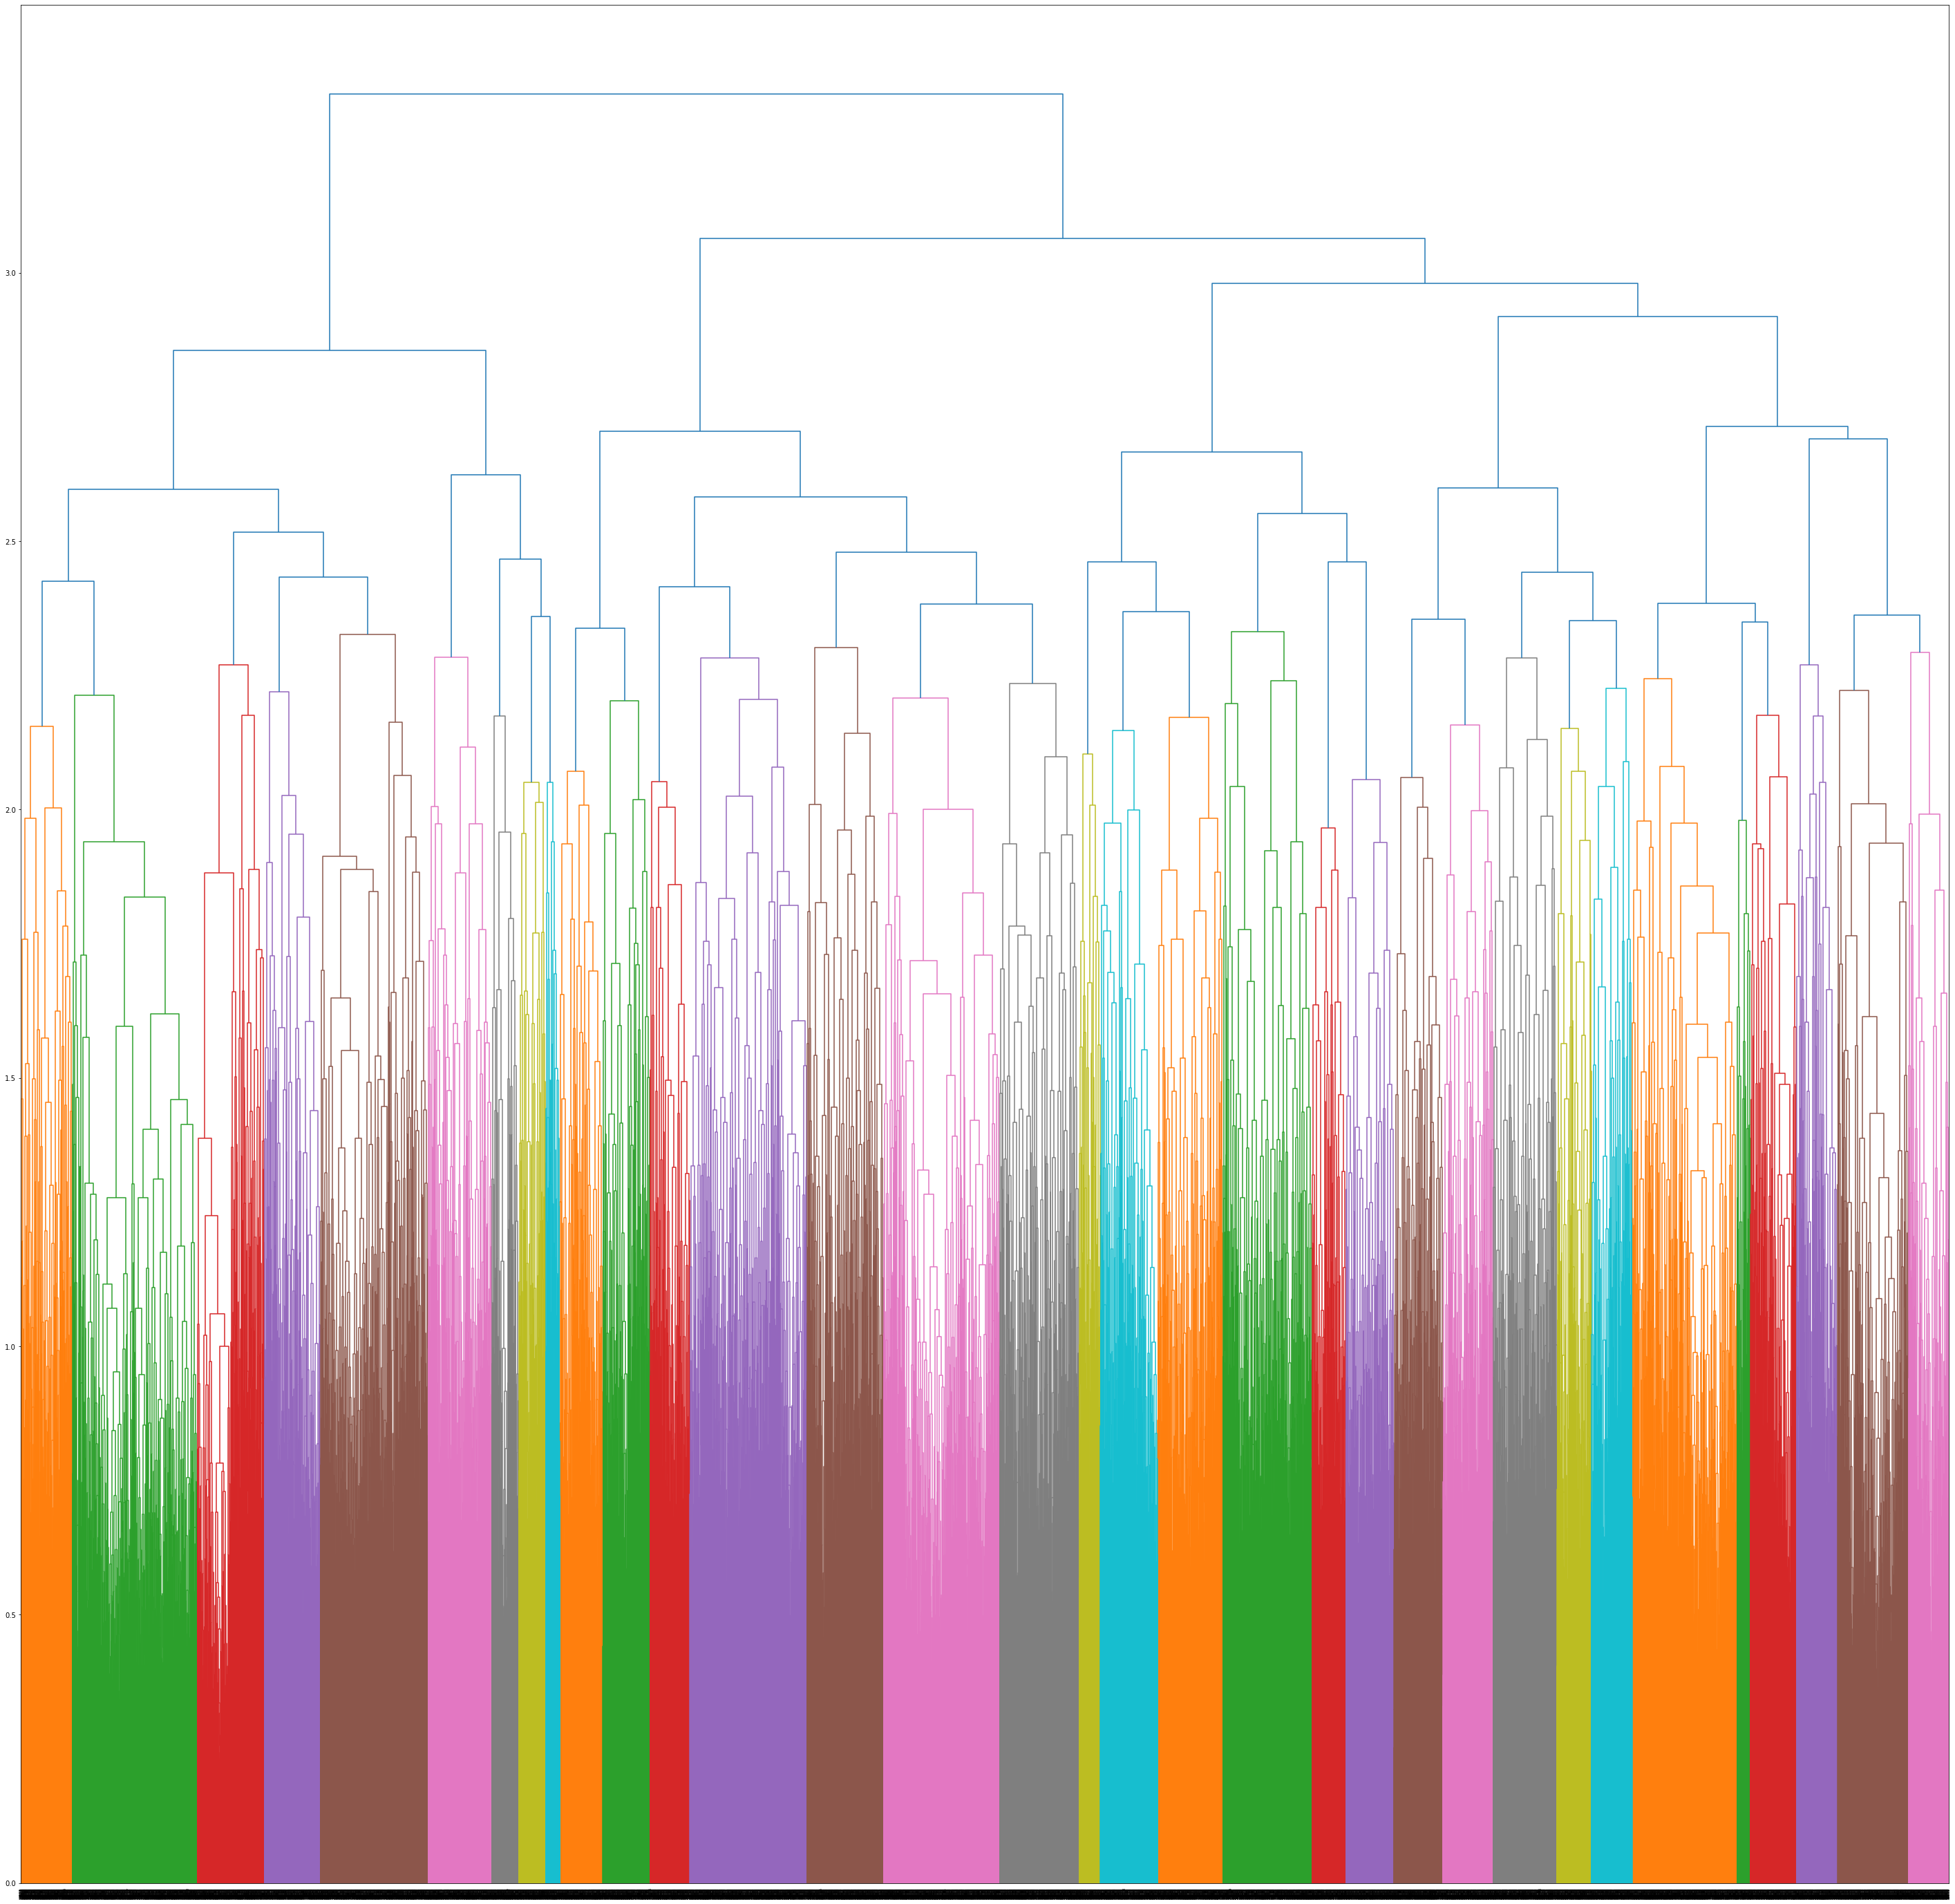

In [ ]:
fig = plt.figure(figsize=(50, 50))
dn = dendrogram(complete_clustering)
plt.show()